# Installing Packages

In [1]:
# Colab: install extra packages
!pip install -q xgboost lightgbm catboost shap joblib
# Optional: fastparquet or geopandas if you want geospatial ops later

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 MB 10.2 MB/s eta 0:00:00


# Importing required libraries

In [2]:
# Standard imports
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_recall_fscore_support, roc_auc_score, cohen_kappa_score)
import joblib
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

# Loading the dataset

In [3]:
# If you uploaded to Colab files, use:
DATA_PATH = "/content/final_dataset1.csv"  # change if you uploaded elsewhere

df = pd.read_csv(DATA_PATH)
print("Rows, cols:", df.shape)
df.head()

Rows, cols: (87, 20)


,system:index,ADM0_CODE,ADM0_NAME,ADM1_CODE,ADM1_NAME,ADM2_CODE,ADM2_NAME,DISP_AREA,EXP2_YEAR,NDVI,Rainfall,STATUS,STR2_YEAR,Shape_Area,Shape_Leng,Soil_pH,.geo,Season,ADM2_NAME_clean,dominant_crop
0,000200000000000002a7,115,India,1508,Tamil Nadu,17866,Thoothukudi,NO,3000,0.324686,0.209,Member State,1000,0.389138,4.374898,77.0,"{""type"":""Point"",""coordinates"":[77.988744560917...",Kharif,thoothukudi,COCONUT
1,000200000000000002a8,115,India,1508,Tamil Nadu,17867,Coimbatore,NO,3000,0.398314,0.919,Member State,1000,0.612299,5.593131,74.0,"{""type"":""Point"",""coordinates"":[77.071985821400...",Kharif,coimbatore,BANANA
2,000200000000000002a9,115,India,1508,Tamil Nadu,17868,Dharmapuri,NO,3000,0.524529,0.614,Member State,1000,0.801692,5.990820,67.0,"{""type"":""Point"",""coordinates"":[78.097616195112...",Kharif,dharmapuri,MAIZE
3,000200000000000002aa,115,India,1508,Tamil Nadu,17869,Virudhunagar,NO,3000,0.374357,0.265,Member State,1000,0.353163,4.514610,74.0,"{""type"":""Point"",""coordinates"":[77.894321753501...",Kharif,virudhunagar,GROUNDNUT
4,000200000000000002ab,115,India,1508,Tamil Nadu,17870,Kanniyakumari,NO,3000,0.739114,0.475,Member State,1000,0.130662,2.129484,59.0,"{""type"":""Point"",""coordinates"":[77.346370192606...",Kharif,kanniyakumari,BANANA


# Quick insights about the dataset

In [4]:
# Quick look
df.info()
display(df.describe(include='all').T)

# Standardize column names if needed
df.columns = [c.strip() for c in df.columns]

# If soil pH appears scaled (like 69-77), rescale it to 0-14 assuming factor 10
if df['Soil_pH'].max() > 20:
    print("Rescaling Soil_pH by /10")
    df['Soil_pH'] = df['Soil_pH'] / 10.0

# If NDVI and Rainfall look normalized, keep. If geo is string, parse lat/lon
if '.geo' in df.columns:
    def parse_geo(g):
        try:
            d = json.loads(g.replace("'", '"')) if isinstance(g, str) else g
            if isinstance(d, dict) and 'coordinates' in d:
                lon, lat = d['coordinates']
                return lat, lon
        except Exception:
            try:
                # sometimes literal_eval works
                d = literal_eval(g)
                if isinstance(d, dict) and 'coordinates' in d:
                    lon, lat = d['coordinates']
                    return lat, lon
            except:
                return (np.nan, np.nan)
        return (np.nan, np.nan)

    lat_lon = df['.geo'].fillna('').apply(parse_geo)
    df['lat'] = [x[0] for x in lat_lon]
    df['lon'] = [x[1] for x in lat_lon]

# Drop obviously useless columns
drop_cols = [c for c in ['system:index','ADM0_NAME','.geo','DISP_AREA','STATUS'] if c in df.columns]
df = df.drop(columns=drop_cols)
print("After cleanup:", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   system:index     87 non-null     object 
 1   ADM0_CODE        87 non-null     int64  
 2   ADM0_NAME        87 non-null     object 
 3   ADM1_CODE        87 non-null     int64  
 4   ADM1_NAME        87 non-null     object 
 5   ADM2_CODE        87 non-null     int64  
 6   ADM2_NAME        87 non-null     object 
 7   DISP_AREA        87 non-null     object 
 8   EXP2_YEAR        87 non-null     int64  
 9   NDVI             87 non-null     float64
 10  Rainfall         87 non-null     float64
 11  STATUS           87 non-null     object 
 12  STR2_YEAR        87 non-null     int64  
 13  Shape_Area       87 non-null     float64
 14  Shape_Leng       87 non-null     float64
 15  Soil_pH          84 non-null     float64
 16  .geo             87 non-null     object 
 17  Season           8

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
system:index,87,29,000200000000000002a7,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADM0_CODE,87.0,NaN,NaN,NaN,115.0,0.0,115.0,115.0,115.0,115.0,115.0
ADM0_NAME,87,1,India,87,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADM1_CODE,87.0,NaN,NaN,NaN,1508.0,0.0,1508.0,1508.0,1508.0,1508.0,1508.0
ADM1_NAME,87,1,Tamil Nadu,87,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADM2_CODE,87.0,NaN,NaN,NaN,43158.482759,26322.399887,17866.0,17876.0,17884.0,70247.0,70255.0
ADM2_NAME,87,29,Thoothukudi,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DISP_AREA,87,1,NO,87,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EXP2_YEAR,87.0,NaN,NaN,NaN,3000.0,0.0,3000.0,3000.0,3000.0,3000.0,3000.0
NDVI,87.0,NaN,NaN,NaN,0.492774,0.123432,0.238778,0.394332,0.506014,0.571124,0.776756


Rescaling Soil_pH by /10
After cleanup: (87, 17)


# Plotting numeric features

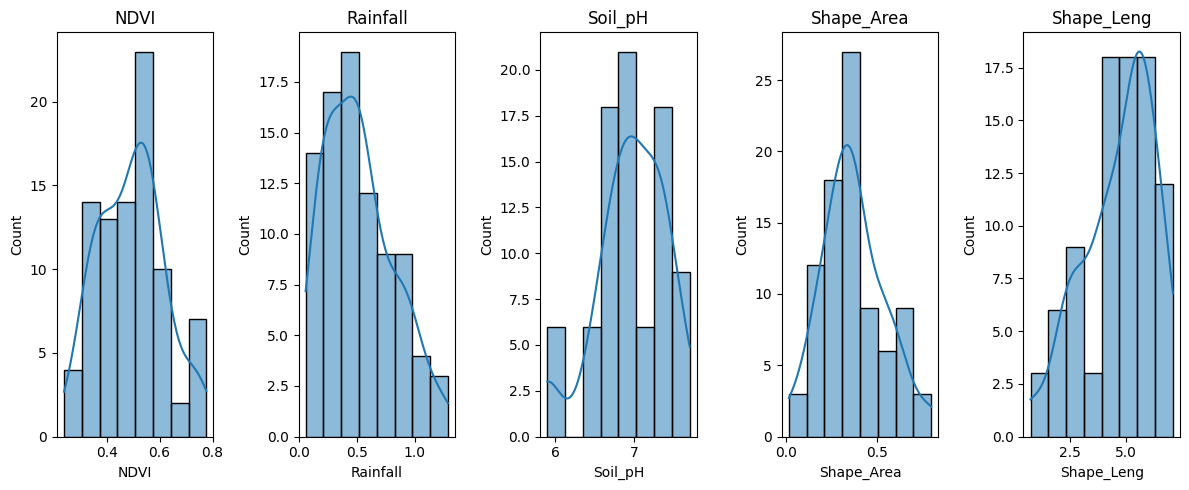

In [5]:
# Numeric features
num_cols = ['NDVI','Rainfall','Soil_pH','Shape_Area','Shape_Leng']
num_cols = [c for c in num_cols if c in df.columns]

plt.figure(figsize=(12,5))
for i, c in enumerate(num_cols):
    plt.subplot(1, len(num_cols), i+1)
    sns.histplot(df[c].dropna(), kde=True)
    plt.title(c)
plt.tight_layout()

# NDVI by crop boxplot

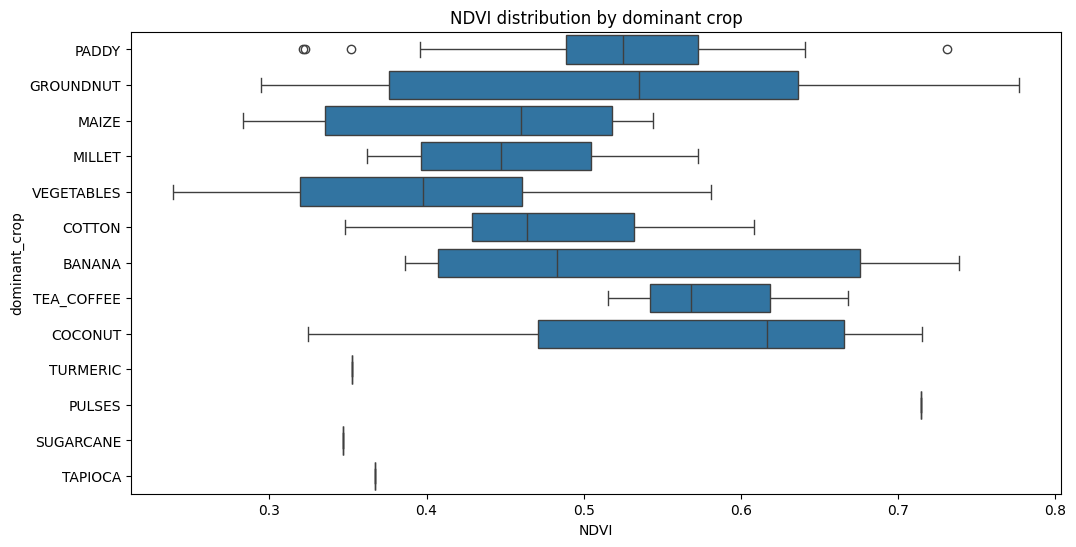

In [6]:
# NDVI by crop (boxplot)
if 'dominant_crop' in df.columns:
    plt.figure(figsize=(12,6))
    order = df['dominant_crop'].value_counts().index
    sns.boxplot(y='dominant_crop', x='NDVI', data=df, order=order)
    plt.title("NDVI distribution by dominant crop")

# Data cleaning

In [7]:
# Missing values summary
df.isnull().sum()

# Strategy:
# - For numeric features: fill with district-season mean or global mean
# - For lat/lon: allow NaN (some models can handle)
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [c for c in numeric_features if c not in ['EXP2_YEAR','STR2_YEAR']]  # drop those if not relevant

# Fill numeric missing values with median
for col in numeric_features:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

# For categorical columns: fill with 'Unknown'
for cat in ['Season','dominant_crop','ADM2_NAME','ADM1_NAME','ADM2_NAME_clean']:
    if cat in df.columns:
        df[cat] = df[cat].fillna('Unknown')

# Unique crops

In [8]:
# Convert Season to categorical; ensure consistent naming
if 'Season' in df.columns:
    df['Season'] = df['Season'].astype(str).str.title().replace({'Kharif':'Kharif','Rabi':'Rabi','Zaid':'Zaid'})

# Create a 'district-season' id for potential group-splits
if 'ADM2_NAME_clean' in df.columns and 'Season' in df.columns:
    df['district_season'] = df['ADM2_NAME_clean'].astype(str) + "_" + df['Season'].astype(str)

# Standardize columns we will use
features = ['NDVI','Rainfall','Soil_pH','lat','lon','Shape_Area','Shape_Leng','Season']
# keep only features that exist
features = [f for f in features if f in df.columns]

# Encode target
le_crop = LabelEncoder()
df['crop_label'] = le_crop.fit_transform(df['dominant_crop'].astype(str))
print("Unique crops:", len(le_crop.classes_), le_crop.classes_)

Unique crops: 13 ['BANANA' 'COCONUT' 'COTTON' 'GROUNDNUT' 'MAIZE' 'MILLET' 'PADDY' 'PULSES'
 'SUGARCANE' 'TAPIOCA' 'TEA_COFFEE' 'TURMERIC' 'VEGETABLES']


# Splitting the data for training

In [9]:
# Count each crop's occurrences
crop_counts = df['dominant_crop'].value_counts()

# Keep only crops with at least 2 samples
valid_crops = crop_counts[crop_counts >= 2].index
df = df[df['dominant_crop'].isin(valid_crops)].reset_index(drop=True)

# Now re-encode labels
le_crop = LabelEncoder()
df['crop_label'] = le_crop.fit_transform(df['dominant_crop'])

# Retry the split
X = df[features].copy()
y = df['crop_label']
X['Season'] = X['Season'].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (66, 8) Test: (17, 8)


# Setting up the pipeline

In [10]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Model Building

In [11]:
# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,
    ExtraTreesClassifier, VotingClassifier, StackingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

models = {
    'LogisticRegression': LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    'ExtraTrees': ExtraTreesClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'AdaBoost': AdaBoostClassifier(random_state=RANDOM_STATE),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=-1, verbosity=0),
    'LightGBM': lgb.LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1),
    'CatBoost': CatBoostClassifier(verbose=0, random_seed=RANDOM_STATE),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(probability=True, random_state=RANDOM_STATE),
    'GaussianNB': GaussianNB(),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=RANDOM_STATE),
}

# Define ensemble models cleanly
# --- Voting Ensemble (soft voting over top tree-based models)
voters = [
    ('rf', models['RandomForest']),
    ('xgb', models['XGBoost']),
    ('lgb', models['LightGBM']),
]
models['Voting_Ensemble'] = VotingClassifier(estimators=voters, voting='soft', n_jobs=-1)

# --- Stacking Ensemble (meta-learning)
stack_base = [
    ('rf', models['RandomForest']),
    ('xgb', models['XGBoost']),
    ('lgb', models['LightGBM']),
]
models['Stacking_Ensemble'] = StackingClassifier(
    estimators=stack_base,
    final_estimator=LogisticRegression(max_iter=2000),
    n_jobs=-1
)

print("✅ All models initialized — LightGBM & CatBoost silenced, Voting & Stacking ensembles added.")
print("Total models:", len(models))

✅ All models initialized — LightGBM & CatBoost silenced, Voting & Stacking ensembles added.
Total models: 15


# Model Training

In [12]:
from sklearn.preprocessing import label_binarize
from collections import defaultdict
import time
from sklearn.metrics import roc_auc_score

def train_and_evaluate(models_dict, preprocessor, X_train, X_test, y_train, y_test):
    results = []
    fitted_models = {}
    for name, model in models_dict.items():
        print(f"\nTraining {name} ...")
        start = time.time()
        pipe = Pipeline(steps=[('preproc', preprocessor),
                               ('clf', model)])
        # Fit
        pipe.fit(X_train, y_train)
        # Predict
        y_pred = pipe.predict(X_test)
        y_prob = None
        try:
            y_prob = pipe.predict_proba(X_test)
        except Exception:
            # Some classifiers may not support predict_proba
            pass

        acc = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)
        kappa = cohen_kappa_score(y_test, y_pred)

        # multiclass AUC (one-vs-rest) if probabilities exist
        auc = np.nan
        if y_prob is not None:
            try:
                classes = np.unique(y_test)
                # binarize
                y_test_bin = label_binarize(y_test, classes=classes)
                if y_prob.shape[1] == y_test_bin.shape[1]:
                    auc = roc_auc_score(y_test_bin, y_prob, average='weighted', multi_class='ovr')
            except Exception:
                auc = np.nan

        elapsed = time.time() - start
        print(f"{name} done in {elapsed:.1f}s — acc: {acc:.3f} f1: {f1:.3f}")

        results.append({'model': name, 'accuracy': acc, 'f1_weighted': f1, 'precision': precision, 'recall': recall,
                        'kappa': kappa, 'time_s': elapsed})
        fitted_models[name] = pipe

    results_df = pd.DataFrame(results).sort_values('f1_weighted', ascending=False).reset_index(drop=True)
    return results_df, fitted_models

results_df, fitted_models = train_and_evaluate(models, preprocessor, X_train, X_test, y_train, y_test)
results_df


Training LogisticRegression ...
LogisticRegression done in 0.2s — acc: 0.471 f1: 0.436

Training DecisionTree ...
DecisionTree done in 0.1s — acc: 0.353 f1: 0.329

Training RandomForest ...
RandomForest done in 0.9s — acc: 0.412 f1: 0.388

Training ExtraTrees ...
ExtraTrees done in 0.6s — acc: 0.588 f1: 0.531

Training GradientBoosting ...
GradientBoosting done in 2.1s — acc: 0.588 f1: 0.523

Training AdaBoost ...
AdaBoost done in 0.2s — acc: 0.353 f1: 0.286

Training XGBoost ...
XGBoost done in 1.3s — acc: 0.412 f1: 0.329

Training LightGBM ...
LightGBM done in 0.4s — acc: 0.588 f1: 0.547

Training CatBoost ...
CatBoost done in 6.0s — acc: 0.353 f1: 0.353

Training KNN ...
KNN done in 0.0s — acc: 0.294 f1: 0.284

Training SVC ...
SVC done in 0.0s — acc: 0.471 f1: 0.369

Training GaussianNB ...
GaussianNB done in 0.0s — acc: 0.529 f1: 0.545

Training MLP ...
MLP done in 0.9s — acc: 0.412 f1: 0.408

Training Voting_Ensemble ...
Voting_Ensemble done in 4.3s — acc: 0.471 f1: 0.390

Train

,model,accuracy,f1_weighted,precision,recall,kappa,time_s
0,LightGBM,0.588235,0.546881,0.576471,0.588235,0.495763,0.406904
1,GaussianNB,0.529412,0.545098,0.656863,0.529412,0.438017,0.034627
2,ExtraTrees,0.588235,0.530532,0.514706,0.588235,0.466368,0.621843
3,GradientBoosting,0.588235,0.523077,0.505602,0.588235,0.482609,2.093834
4,LogisticRegression,0.470588,0.436415,0.436275,0.470588,0.325991,0.202680
5,MLP,0.411765,0.407843,0.480392,0.411765,0.294606,0.939836
6,Voting_Ensemble,0.470588,0.389744,0.338936,0.470588,0.328947,4.330186
7,RandomForest,0.411765,0.388235,0.401961,0.411765,0.267241,0.872750
8,Stacking_Ensemble,0.470588,0.368627,0.303922,0.470588,0.301370,5.598456
9,SVC,0.470588,0.368627,0.386555,0.470588,0.231156,0.045373


# Classification Report of each model


Model: LightGBM
              precision    recall  f1-score   support

      BANANA       1.00      1.00      1.00         1
     COCONUT       0.00      0.00      0.00         1
      COTTON       0.00      0.00      0.00         1
   GROUNDNUT       0.33      1.00      0.50         2
       MAIZE       1.00      0.50      0.67         2
      MILLET       0.00      0.00      0.00         2
       PADDY       0.80      0.67      0.73         6
  VEGETABLES       0.67      1.00      0.80         2

    accuracy                           0.59        17
   macro avg       0.47      0.52      0.46        17
weighted avg       0.58      0.59      0.55        17



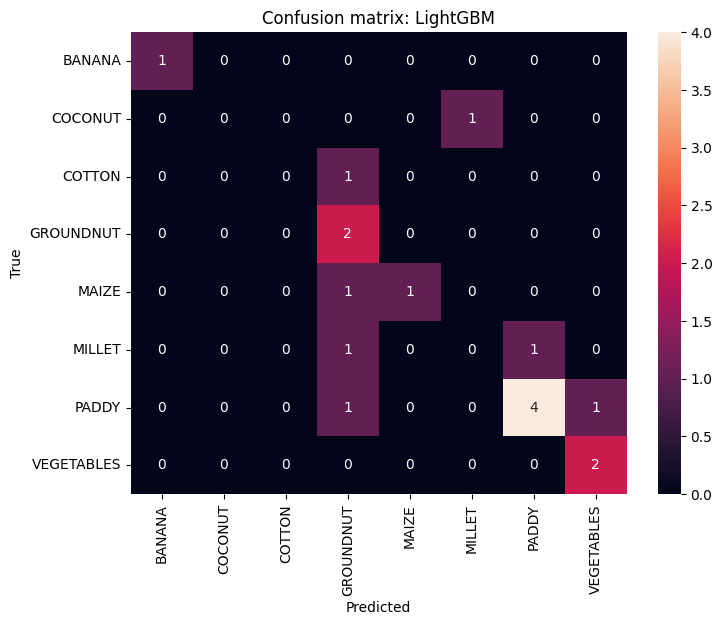


Model: GaussianNB
              precision    recall  f1-score   support

      BANANA       0.00      0.00      0.00         1
     COCONUT       0.00      0.00      0.00         1
      COTTON       0.00      0.00      0.00         1
   GROUNDNUT       1.00      1.00      1.00         2
       MAIZE       1.00      0.50      0.67         2
      MILLET       0.33      1.00      0.50         2
       PADDY       0.75      0.50      0.60         6
  VEGETABLES       1.00      0.50      0.67         2

    accuracy                           0.53        17
   macro avg       0.51      0.44      0.43        17
weighted avg       0.66      0.53      0.55        17



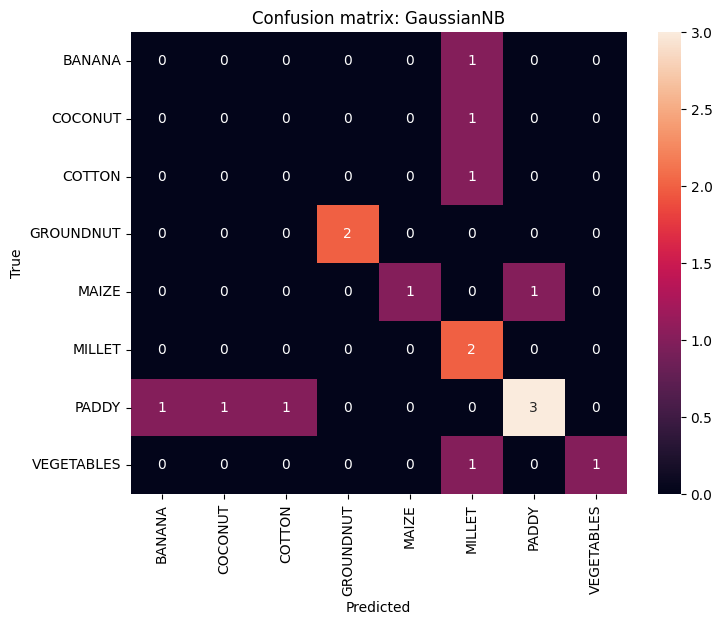


Model: ExtraTrees
              precision    recall  f1-score   support

      BANANA       0.00      0.00      0.00         1
     COCONUT       0.00      0.00      0.00         1
      COTTON       0.00      0.00      0.00         1
   GROUNDNUT       0.50      0.50      0.50         2
       MAIZE       1.00      0.50      0.67         2
      MILLET       0.33      0.50      0.40         2
       PADDY       0.62      0.83      0.71         6
  VEGETABLES       0.67      1.00      0.80         2

    accuracy                           0.59        17
   macro avg       0.39      0.42      0.39        17
weighted avg       0.51      0.59      0.53        17



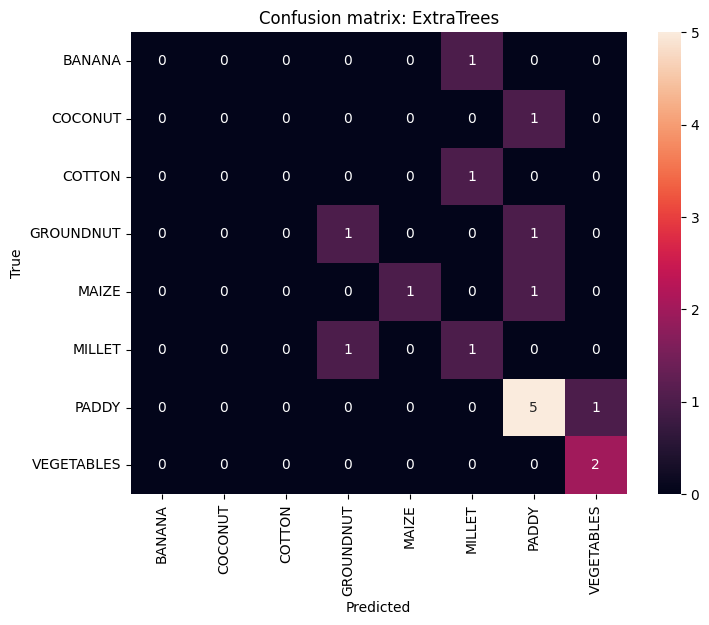


Model: GradientBoosting
              precision    recall  f1-score   support

      BANANA       0.00      0.00      0.00         1
     COCONUT       0.50      1.00      0.67         1
      COTTON       0.00      0.00      0.00         1
   GROUNDNUT       0.67      1.00      0.80         2
       MAIZE       1.00      0.50      0.67         2
      MILLET       0.00      0.00      0.00         2
       PADDY       0.57      0.67      0.62         6
  VEGETABLES       0.67      1.00      0.80         2

    accuracy                           0.59        17
   macro avg       0.43      0.52      0.44        17
weighted avg       0.51      0.59      0.52        17



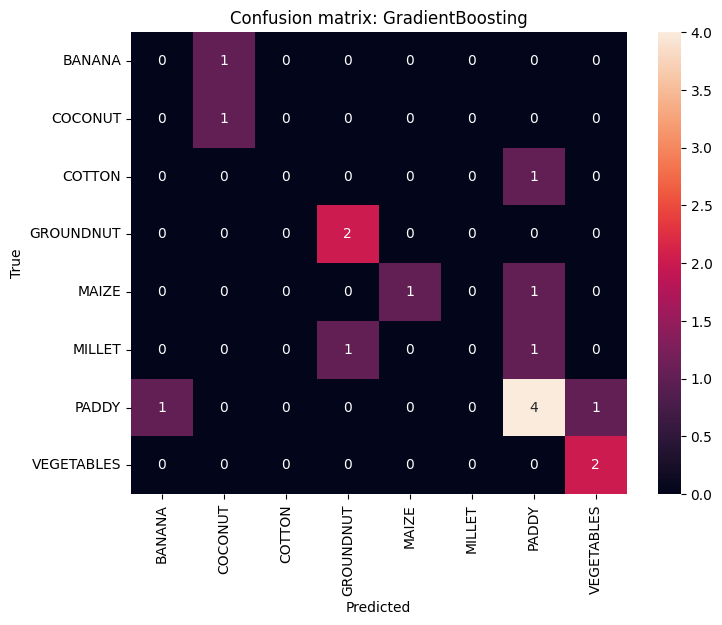


Model: LogisticRegression
              precision    recall  f1-score   support

      BANANA       0.00      0.00      0.00         1
     COCONUT       0.00      0.00      0.00         1
      COTTON       1.00      1.00      1.00         1
   GROUNDNUT       0.33      0.50      0.40         2
       MAIZE       0.00      0.00      0.00         2
      MILLET       0.00      0.00      0.00         2
       PADDY       0.62      0.83      0.71         6
  VEGETABLES       1.00      0.50      0.67         2

    accuracy                           0.47        17
   macro avg       0.37      0.35      0.35        17
weighted avg       0.44      0.47      0.44        17



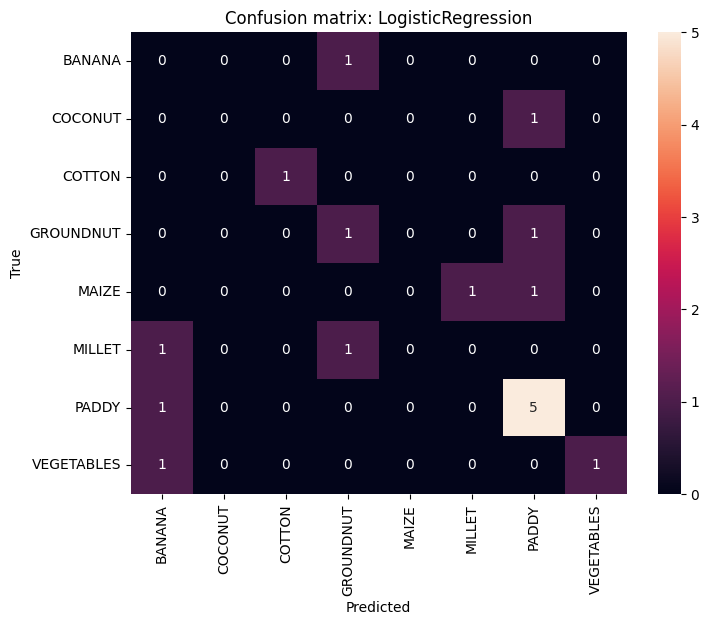


Model: MLP
              precision    recall  f1-score   support

      BANANA       0.00      0.00      0.00         1
     COCONUT       0.00      0.00      0.00         1
      COTTON       0.00      0.00      0.00         1
   GROUNDNUT       0.33      1.00      0.50         2
       MAIZE       0.50      0.50      0.50         2
      MILLET       0.00      0.00      0.00         2
       PADDY       0.75      0.50      0.60         6
  VEGETABLES       1.00      0.50      0.67         2

    accuracy                           0.41        17
   macro avg       0.32      0.31      0.28        17
weighted avg       0.48      0.41      0.41        17



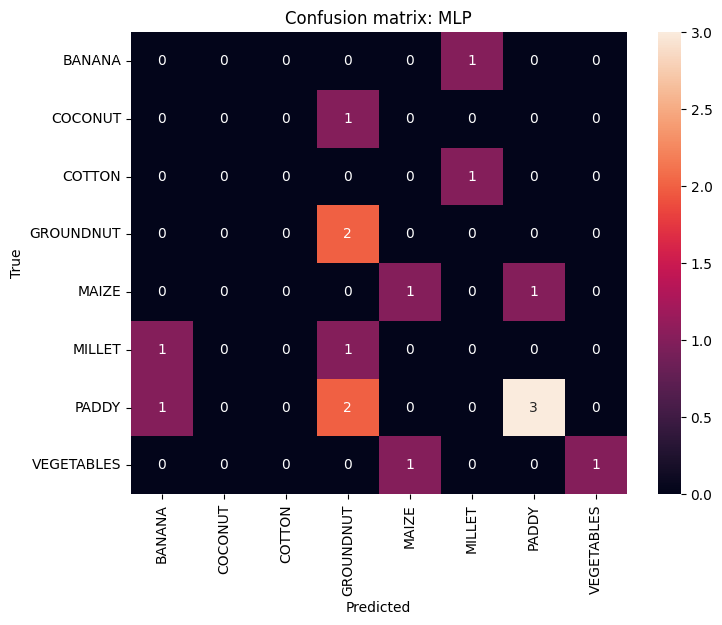


Model: Voting_Ensemble
              precision    recall  f1-score   support

      BANANA       0.00      0.00      0.00         1
     COCONUT       0.00      0.00      0.00         1
      COTTON       0.00      0.00      0.00         1
   GROUNDNUT       0.50      1.00      0.67         2
       MAIZE       0.00      0.00      0.00         2
      MILLET       0.00      0.00      0.00         2
       PADDY       0.57      0.67      0.62         6
  VEGETABLES       0.67      1.00      0.80         2

    accuracy                           0.47        17
   macro avg       0.22      0.33      0.26        17
weighted avg       0.34      0.47      0.39        17



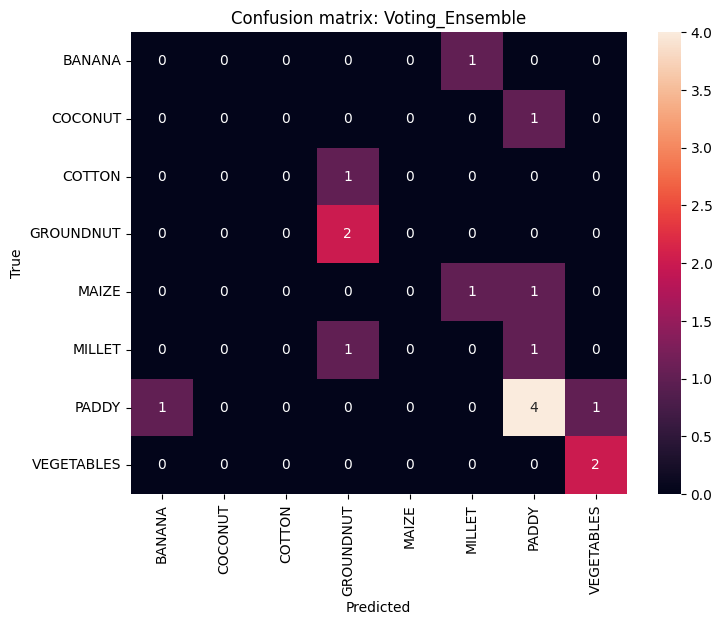


Model: RandomForest
              precision    recall  f1-score   support

      BANANA       0.00      0.00      0.00         1
     COCONUT       0.00      0.00      0.00         1
      COTTON       0.00      0.00      0.00         1
   GROUNDNUT       0.25      0.50      0.33         2
       MAIZE       1.00      0.50      0.67         2
      MILLET       0.00      0.00      0.00         2
       PADDY       0.50      0.50      0.50         6
  VEGETABLES       0.67      1.00      0.80         2

    accuracy                           0.41        17
   macro avg       0.30      0.31      0.29        17
weighted avg       0.40      0.41      0.39        17



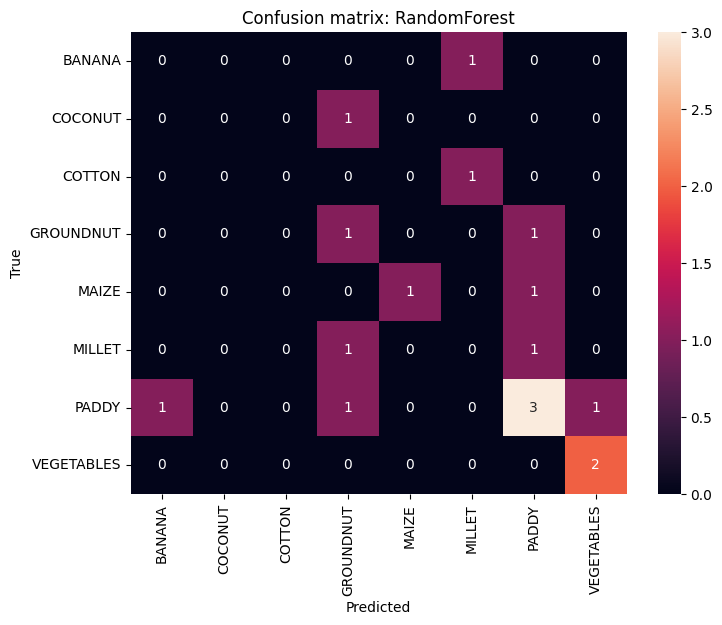


Model: Stacking_Ensemble
              precision    recall  f1-score   support

      BANANA       0.00      0.00      0.00         1
     COCONUT       0.00      0.00      0.00         1
      COTTON       0.00      0.00      0.00         1
   GROUNDNUT       0.00      0.00      0.00         2
       MAIZE       0.00      0.00      0.00         2
      MILLET       0.25      0.50      0.33         2
       PADDY       0.56      0.83      0.67         6
  VEGETABLES       0.67      1.00      0.80         2

    accuracy                           0.47        17
   macro avg       0.18      0.29      0.23        17
weighted avg       0.30      0.47      0.37        17



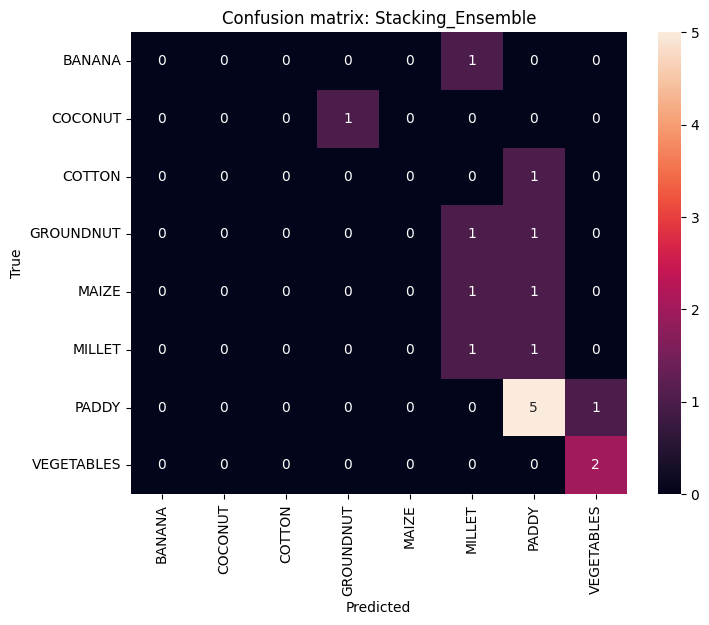


Model: SVC
              precision    recall  f1-score   support

      BANANA       0.00      0.00      0.00         1
     COCONUT       0.00      0.00      0.00         1
      COTTON       0.00      0.00      0.00         1
   GROUNDNUT       0.00      0.00      0.00         2
       MAIZE       1.00      0.50      0.67         2
      MILLET       0.00      0.00      0.00         2
       PADDY       0.43      1.00      0.60         6
  VEGETABLES       1.00      0.50      0.67         2

    accuracy                           0.47        17
   macro avg       0.30      0.25      0.24        17
weighted avg       0.39      0.47      0.37        17



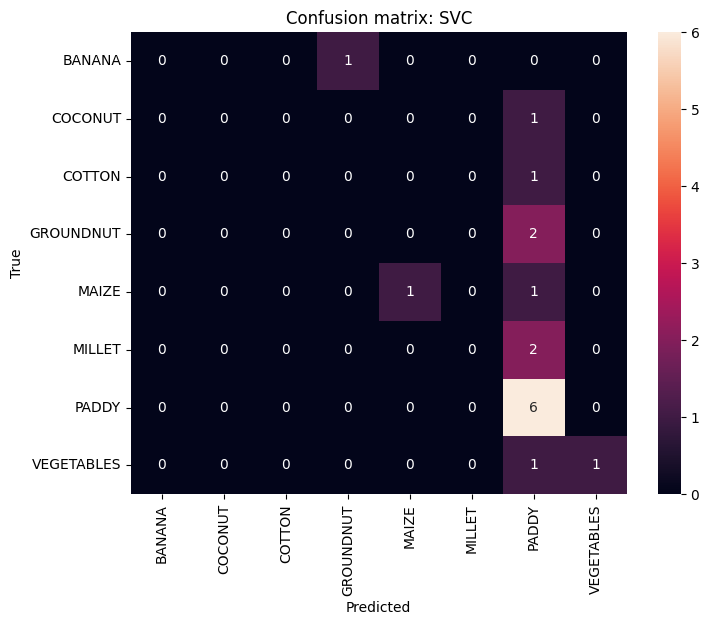


Model: CatBoost
              precision    recall  f1-score   support

      BANANA       0.00      0.00      0.00         1
     COCONUT       0.00      0.00      0.00         1
      COTTON       0.00      0.00      0.00         1
   GROUNDNUT       0.25      0.50      0.33         2
       MAIZE       1.00      0.50      0.67         2
      MILLET       0.00      0.00      0.00         2
       PADDY       0.50      0.50      0.50         6
  VEGETABLES       0.50      0.50      0.50         2

    accuracy                           0.35        17
   macro avg       0.28      0.25      0.25        17
weighted avg       0.38      0.35      0.35        17



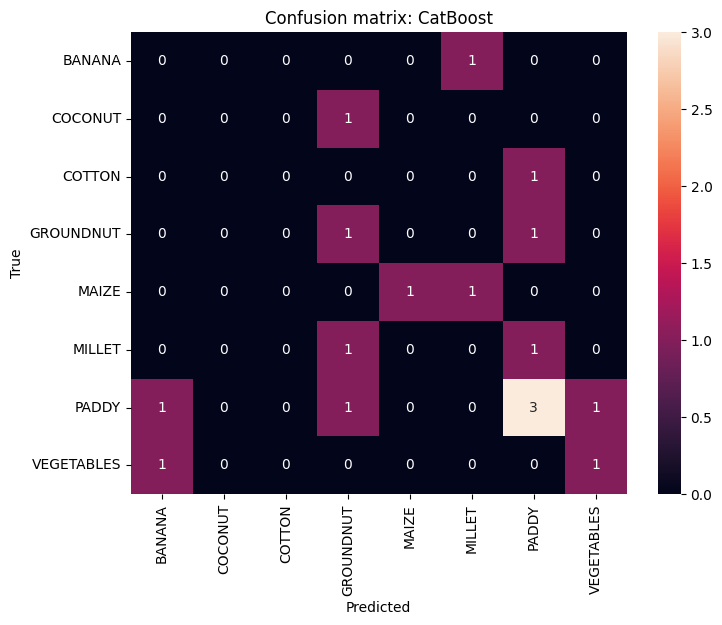


Model: XGBoost
              precision    recall  f1-score   support

      BANANA       0.00      0.00      0.00         1
     COCONUT       0.00      0.00      0.00         1
      COTTON       0.00      0.00      0.00         1
   GROUNDNUT       0.33      0.50      0.40         2
       MAIZE       0.00      0.00      0.00         2
      MILLET       0.00      0.00      0.00         2
       PADDY       0.44      0.67      0.53         6
  VEGETABLES       0.67      1.00      0.80         2

    accuracy                           0.41        17
   macro avg       0.18      0.27      0.22        17
weighted avg       0.27      0.41      0.33        17



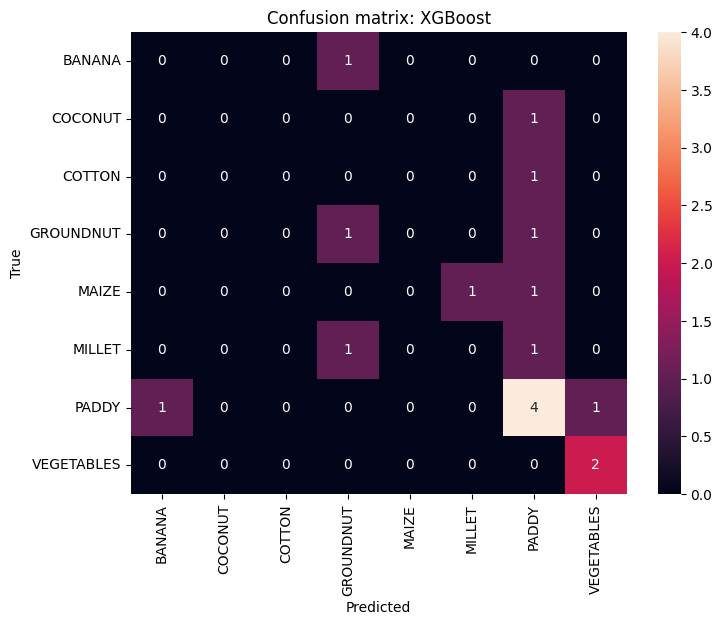


Model: DecisionTree
              precision    recall  f1-score   support

      BANANA       0.00      0.00      0.00         1
     COCONUT       0.00      0.00      0.00         1
      COTTON       0.00      0.00      0.00         1
   GROUNDNUT       0.50      0.50      0.50         2
       MAIZE       0.00      0.00      0.00         2
      MILLET       0.00      0.00      0.00         2
       PADDY       0.50      0.50      0.50         6
  VEGETABLES       0.67      1.00      0.80         2

    accuracy                           0.35        17
   macro avg       0.21      0.25      0.23        17
weighted avg       0.31      0.35      0.33        17



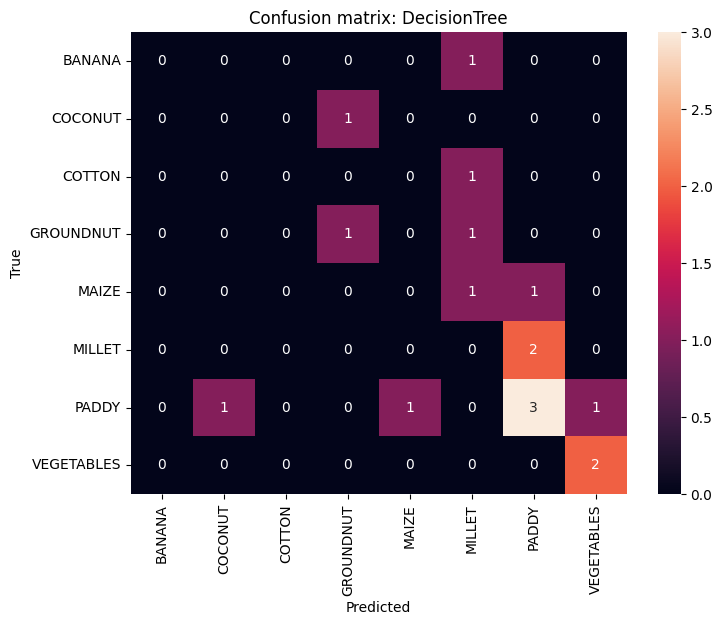


Model: AdaBoost
              precision    recall  f1-score   support

      BANANA       0.00      0.00      0.00         1
     COCONUT       0.00      0.00      0.00         1
      COTTON       0.00      0.00      0.00         1
   GROUNDNUT       0.00      0.00      0.00         2
       MAIZE       0.00      0.00      0.00         2
      MILLET       0.00      0.00      0.00         2
       PADDY       0.45      0.83      0.59         6
  VEGETABLES       1.00      0.50      0.67         2

    accuracy                           0.35        17
   macro avg       0.18      0.17      0.16        17
weighted avg       0.28      0.35      0.29        17



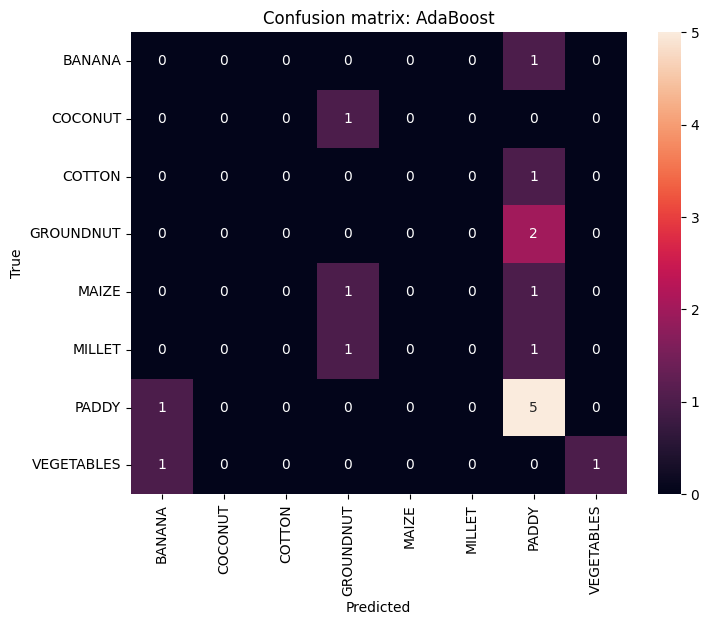


Model: KNN
              precision    recall  f1-score   support

      BANANA       0.00      0.00      0.00         1
     COCONUT       0.00      0.00      0.00         1
      COTTON       0.00      0.00      0.00         1
   GROUNDNUT       0.17      0.50      0.25         2
       MAIZE       1.00      0.50      0.67         2
      MILLET       0.00      0.00      0.00         2
       PADDY       0.50      0.50      0.50         6
  VEGETABLES       0.00      0.00      0.00         2

    accuracy                           0.29        17
   macro avg       0.21      0.19      0.18        17
weighted avg       0.31      0.29      0.28        17



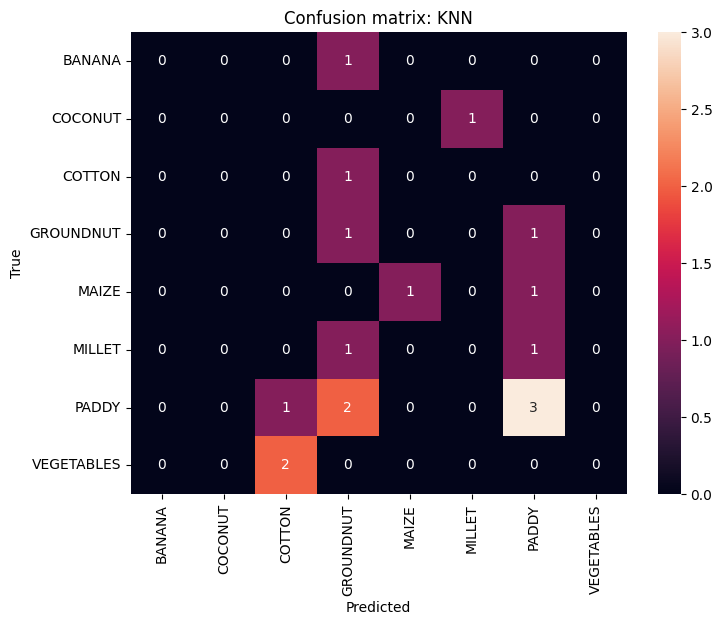

In [13]:
from sklearn.utils.multiclass import unique_labels

top3 = results_df['model']

for m in top3:
    print("\n" + "="*40)
    print("Model:", m)
    pipe = fitted_models[m]
    y_pred = pipe.predict(X_test)

    # --- dynamically match labels ---
    labels_present = unique_labels(y_test, y_pred)
    target_names_present = [le_crop.classes_[i] for i in labels_present]

    # --- print report ---
    print(classification_report(y_test, y_pred, labels=labels_present, target_names=target_names_present))

    # --- confusion matrix ---
    cm = confusion_matrix(y_test, y_pred, labels=labels_present)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=target_names_present, yticklabels=target_names_present)
    plt.title(f"Confusion matrix: {m}")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()


# 5-fold CV

In [14]:
# Example: 5-fold CV for top model
best_model_name = results_df.loc[0,'model']
print("Best model:", best_model_name)
best_pipe = fitted_models[best_model_name]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(best_pipe, X, y, cv=cv, scoring='f1_weighted', n_jobs=-1)
print("CV f1_weighted scores:", cv_scores, "mean:", cv_scores.mean())

Best model: LightGBM
CV f1_weighted scores: [0.37754011 0.6066365  0.5070028  0.3224359  0.35416667] mean: 0.43355639458580636


# XAI SHAP

SHAP for RandomForest


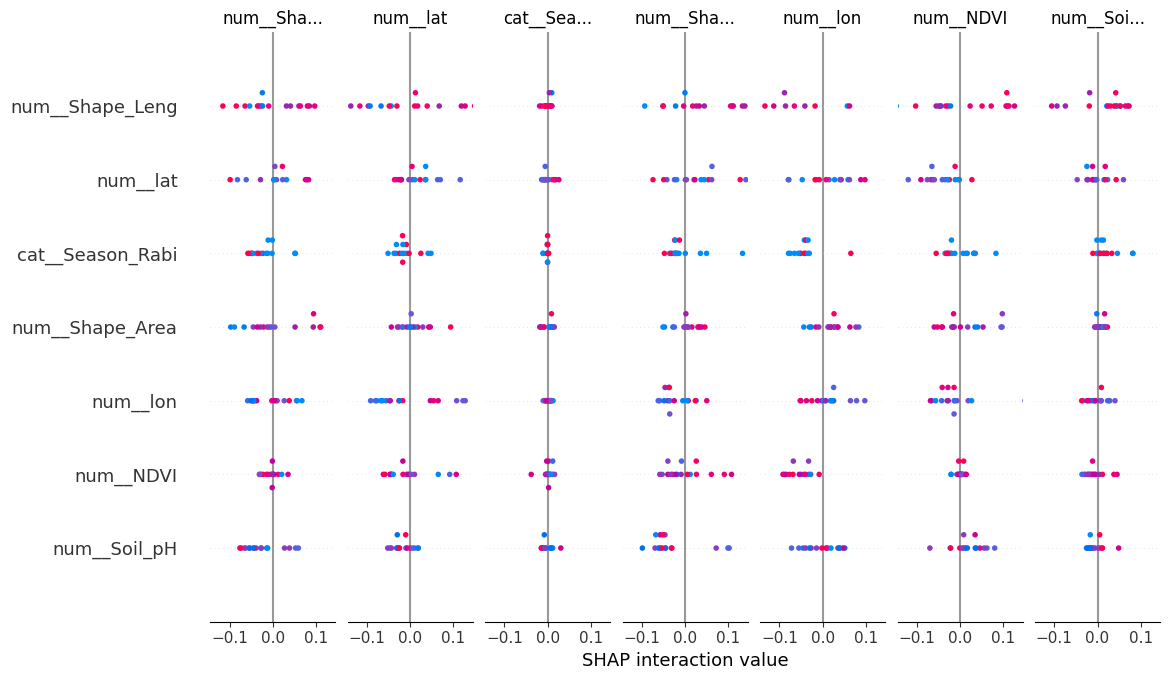

SHAP for XGBoost


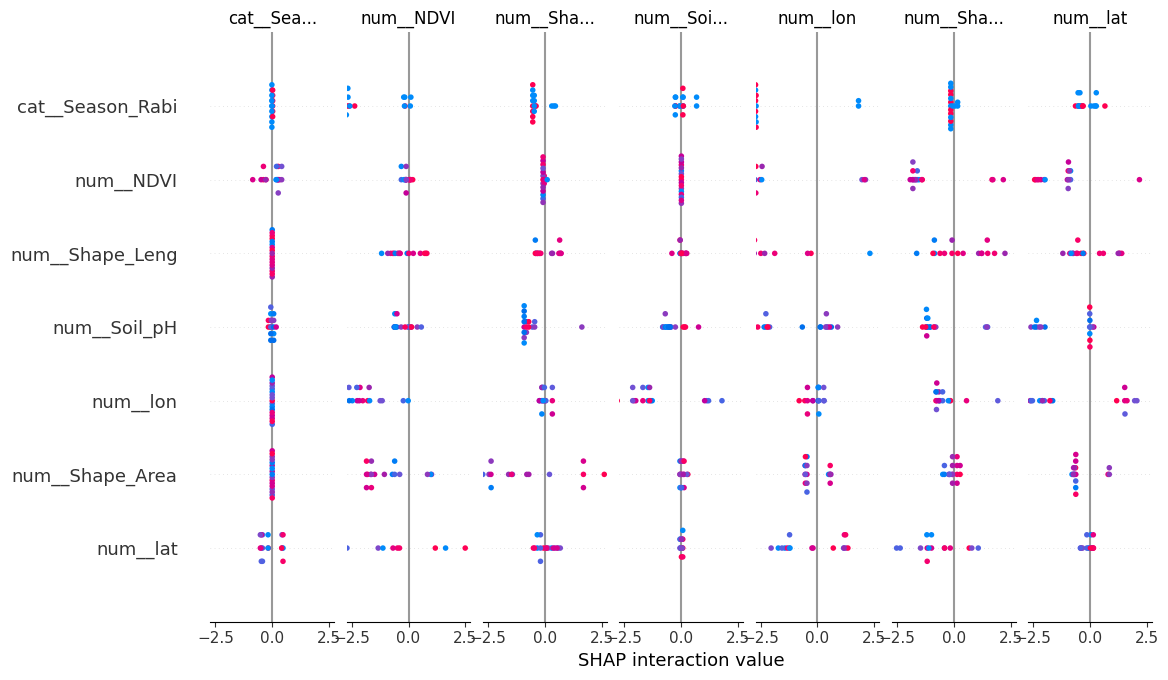

SHAP for LightGBM


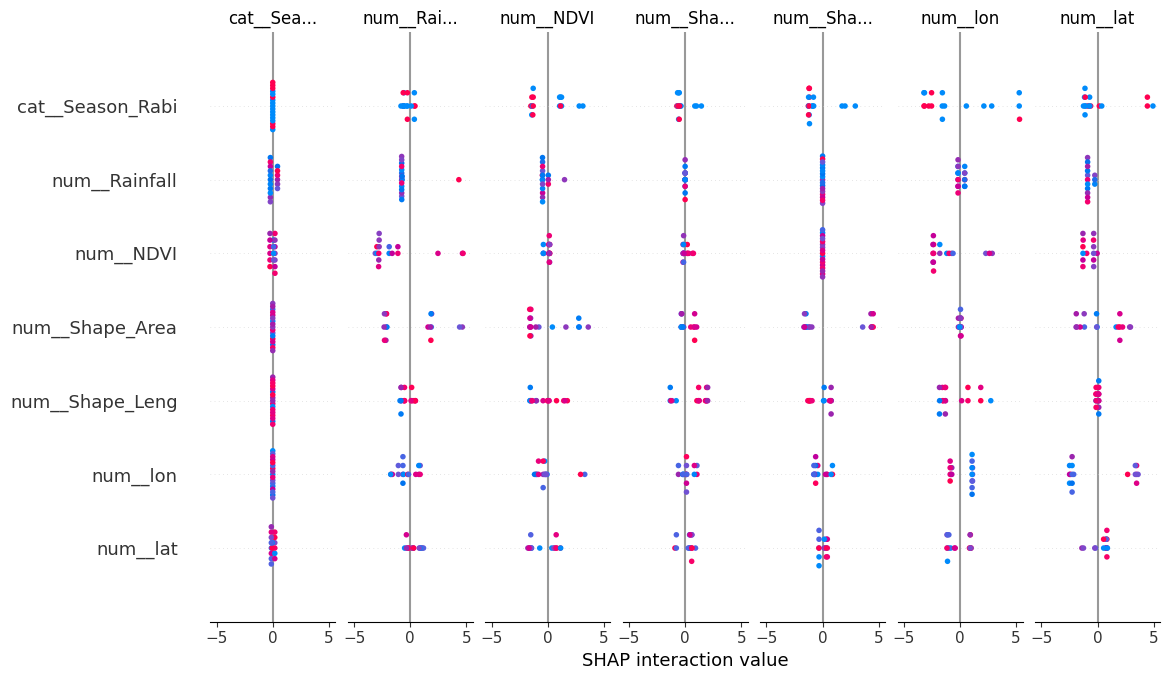

SHAP for ExtraTrees


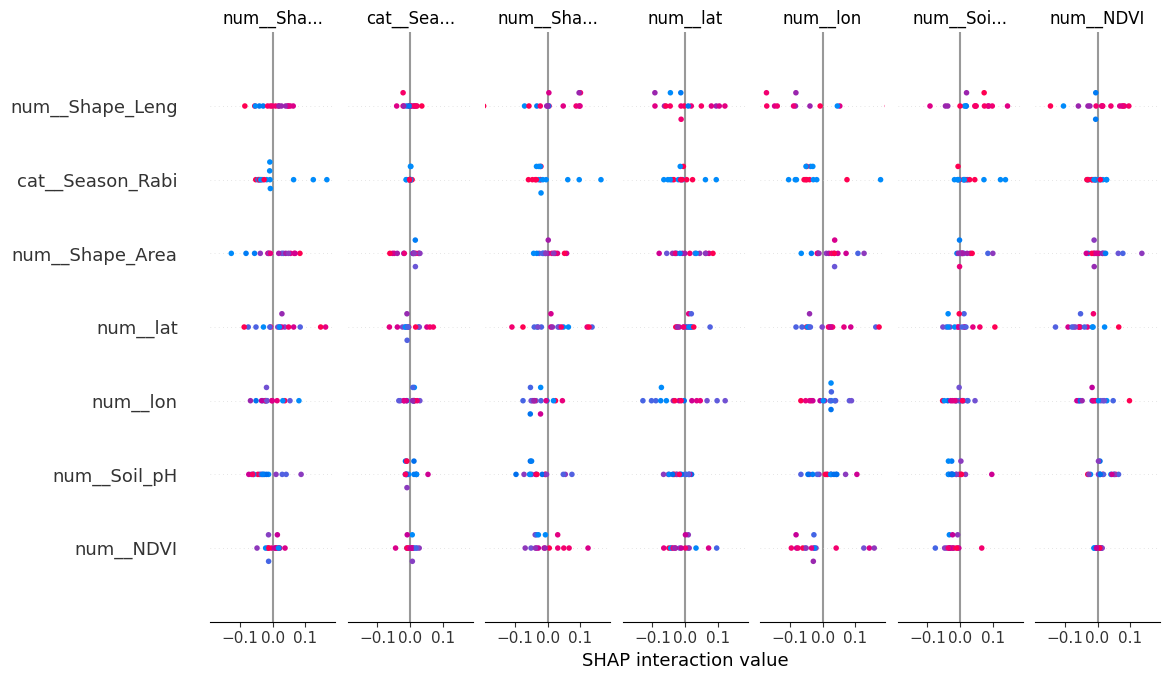

In [15]:
import shap

shap.initjs()

def shap_for_model(pipe, X_sample, n_display=20):
    pre = pipe.named_steps['preproc']
    clf = pipe.named_steps['clf']
    X_trans = pre.transform(X_sample)  # numpy array

    # ✅ NEW: extract correct transformed feature names
    try:
        feature_names = pre.get_feature_names_out()
    except:
        feature_names = [f"feature_{i}" for i in range(X_trans.shape[1])]

    # For tree models, use TreeExplainer if supported
    try:
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X_trans)
    except Exception:
        explainer = shap.KernelExplainer(clf.predict_proba, shap.sample(X_trans, 50))
        shap_values = explainer.shap_values(shap.sample(X_trans, 50))

    # ✅ Use feature names in SHAP summary
    try:
        shap.summary_plot(shap_values, X_trans, feature_names=feature_names, show=True)
    except Exception as e:
        print("Failed to generate SHAP plot:", e)

# Choose a tree model if available
for candidate in ['RandomForest','XGBoost','LightGBM','ExtraTrees']:
    if candidate in fitted_models:
        print("SHAP for", candidate)
        shap_for_model(fitted_models[candidate], X_test.sample(min(50, X_test.shape[0]), random_state=RANDOM_STATE))


In [16]:
# Save top 3 models
top_models = results_df['model'].head(3).tolist()
for m in top_models:
    joblib.dump(fitted_models[m], f"{m}_pipeline.joblib")
    print("Saved:", f"{m}_pipeline.joblib")


Saved: LightGBM_pipeline.joblib
Saved: GaussianNB_pipeline.joblib
Saved: ExtraTrees_pipeline.joblib


#Improving the crop recommendation model accuracies using SMOTE

✅ Dataset loaded: (87, 20)
✅ Remaining crops: 9

✅ SMOTE applied:
BANANA: 28 samples
COCONUT: 28 samples
COTTON: 28 samples
GROUNDNUT: 28 samples
MAIZE: 28 samples
MILLET: 28 samples
PADDY: 28 samples
TEA_COFFEE: 28 samples
VEGETABLES: 28 samples

✅ LogisticRegression Results:
Accuracy: 41.18% | F1_w: 0.299 | Precision: 0.244 | Recall: 0.412 | Kappa: 0.342
⏱ Training + Prediction Time: 0.0077 sec
              precision    recall  f1-score   support

      BANANA       0.00      0.00      0.00         6
     COCONUT       0.20      0.40      0.27         5
      COTTON       0.42      0.83      0.56         6
   GROUNDNUT       0.00      0.00      0.00         6
       MAIZE       0.00      0.00      0.00         6
      MILLET       0.36      1.00      0.53         5
       PADDY       0.00      0.00      0.00         6
  TEA_COFFEE       0.83      1.00      0.91         5
  VEGETABLES       0.50      0.67      0.57         6

    accuracy                           0.41        51
   m

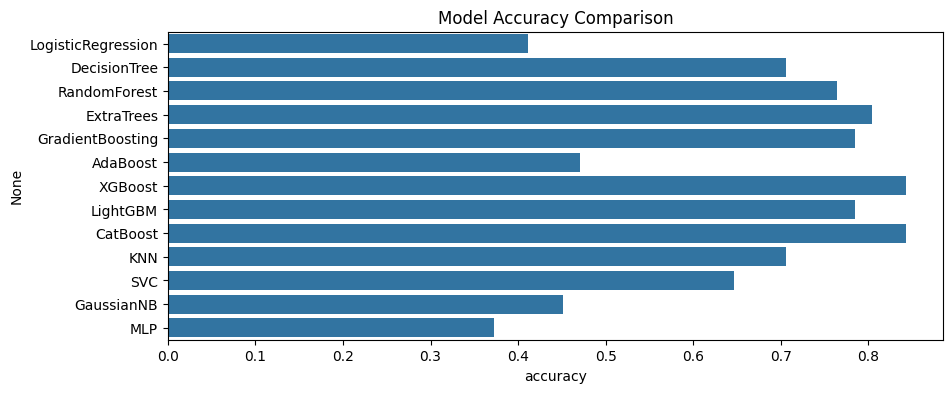


📊 Model Comparison:
                     accuracy  f1_weighted  precision    recall     kappa  \
XGBoost             0.843137     0.816687   0.877218  0.843137  0.823377   
CatBoost            0.843137     0.813161   0.878618  0.843137  0.823377   
ExtraTrees          0.803922     0.780795   0.791363  0.803922  0.779221   
GradientBoosting    0.784314     0.769335   0.775070  0.784314  0.757143   
LightGBM            0.784314     0.771937   0.785808  0.784314  0.757248   
RandomForest        0.764706     0.732366   0.779412  0.764706  0.735180   
DecisionTree        0.705882     0.695873   0.729367  0.705882  0.669118   
KNN                 0.705882     0.656091   0.655696  0.705882  0.668831   
SVC                 0.647059     0.596499   0.663943  0.647059  0.602941   
AdaBoost            0.470588     0.399751   0.420635  0.470588  0.407232   
GaussianNB          0.450980     0.391181   0.379204  0.450980  0.383420   
LogisticRegression  0.411765     0.299456   0.244164  0.411765  0.

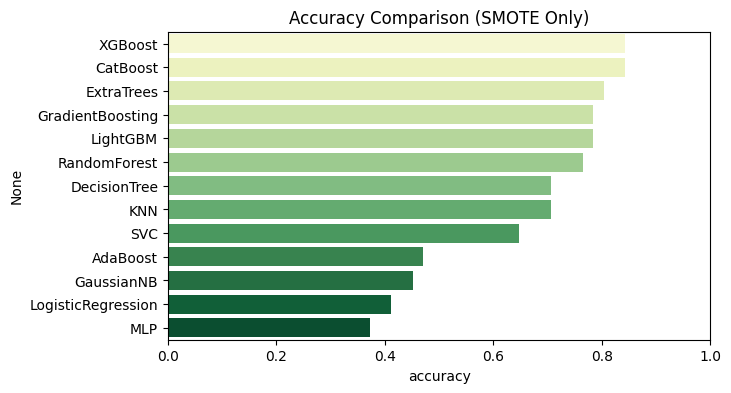

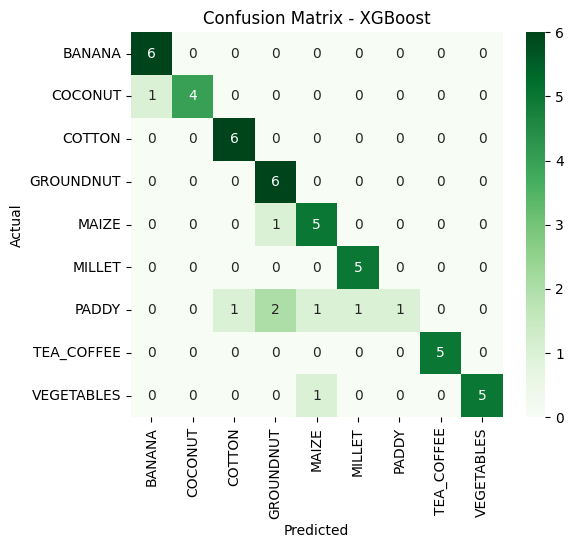


✅ Done!


In [17]:
# ===========================================================
# ✅ SMOTE + Base Models (NO TUNING)
# ===========================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import joblib, warnings
warnings.filterwarnings("ignore")

# ===========================================================
# 1️⃣ Load Dataset
# ===========================================================
df = pd.read_csv("/content/final_dataset1.csv")
print("✅ Dataset loaded:", df.shape)

# ===========================================================
# 2️⃣ Clean Missing Values
# ===========================================================
df['NDVI'].fillna(df['NDVI'].mean(), inplace=True)
df['Rainfall'].fillna(df['Rainfall'].mean(), inplace=True)
df['Soil_pH'].fillna(df['Soil_pH'].mean(), inplace=True)

# ===========================================================
# 3️⃣ Drop Rare Crops (<2 samples)
# ===========================================================
label_counts = df['dominant_crop'].value_counts()
rare_labels = label_counts[label_counts < 2].index
df = df[~df['dominant_crop'].isin(rare_labels)].reset_index(drop=True)

print("✅ Remaining crops:", df['dominant_crop'].nunique())

# ===========================================================
# 4️⃣ Encode & Scale
# ===========================================================
le = LabelEncoder()
df['label'] = le.fit_transform(df['dominant_crop'])

scaler = MinMaxScaler()
X = scaler.fit_transform(df[['NDVI','Rainfall','Soil_pH']])
y = df['label']

# ===========================================================
# 5️⃣ Apply SMOTE ONLY (No tuning)
# ===========================================================
smallest_class_size = df['dominant_crop'].value_counts().min()
k_neighbors = max(1, smallest_class_size - 1)

sm = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_res, y_res = sm.fit_resample(X, y)

print("\n✅ SMOTE applied:")
for i, cls in enumerate(le.classes_):
    print(f"{cls}: {(y_res == i).sum()} samples")

# ===========================================================
# 6️⃣ Train-Test Split
# ===========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

# ===========================================================
# 7️⃣ Base Models (NO tuning)
# ===========================================================
models = {
    'LogisticRegression': LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    'ExtraTrees': ExtraTreesClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'AdaBoost': AdaBoostClassifier(random_state=RANDOM_STATE),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=-1, verbosity=0),
    'LightGBM': lgb.LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1),
    'CatBoost': CatBoostClassifier(verbose=0, random_seed=RANDOM_STATE),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(probability=True, random_state=RANDOM_STATE),
    'GaussianNB': GaussianNB(),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=RANDOM_STATE),
}

results = {}

# ===========================================================
# 8️⃣ Train + Evaluate (EXTENDED METRICS)
# ===========================================================
from sklearn.metrics import precision_score, recall_score, cohen_kappa_score
import time

results = {}

for name, model in models.items():
    start = time.time()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    end = time.time()
    elapsed = end - start

    acc = accuracy_score(y_test, y_pred)
    f1_w = f1_score(y_test, y_pred, average='weighted')
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)

    results[name] = {
        "accuracy": acc,
        "f1_weighted": f1_w,
        "precision": prec,
        "recall": rec,
        "kappa": kappa,
        "time_s": elapsed
    }

    print(f"\n✅ {name} Results:")
    print(f"Accuracy: {acc*100:.2f}% | F1_w: {f1_w:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | Kappa: {kappa:.3f}")
    print(f"⏱ Training + Prediction Time: {elapsed:.4f} sec")
    print(classification_report(y_test, y_pred, target_names=le.classes_))




# ===========================================================
# ✅ Final Full Metrics Table
# ===========================================================
final_df = pd.DataFrame(results).T
print("\n📊 Final Model Metrics:\n")
print(final_df)

plt.figure(figsize=(10,4))
sns.barplot(x=final_df['accuracy'], y=final_df.index)
plt.title("Model Accuracy Comparison")
plt.show()

# ===========================================================
# 9️⃣ Compare Results
# ===========================================================
res_df = pd.DataFrame(results).T.sort_values("accuracy", ascending=False)
print("\n📊 Model Comparison:\n", res_df)

plt.figure(figsize=(7,4))
sns.barplot(x=res_df['accuracy'], y=res_df.index, palette="YlGn")
plt.title("Accuracy Comparison (SMOTE Only)")
plt.xlim(0,1)
plt.show()
# ===========================================================
# 🔟 Confusion Matrix for Best Model
# ===========================================================
best_model = res_df.index[0]
model = models[best_model]
y_pred = model.predict(X_test)

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Greens')
plt.title(f"Confusion Matrix - {best_model}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\n✅ Done!")


#Hyperparameter tuning the model's accuracies with SMOTE



✅ Dataset loaded: (87, 20)
✅ Removed rare crops. Remaining classes: 9
✅ Missing values handled.
✅ SMOTE applied. New shape: (252, 6)

✅ LogisticRegression — Best params: {'solver': 'saga', 'class_weight': None, 'C': 10}
   Accuracy: 62.75% | F1-weighted: 0.597 | F1-macro: 0.614
              precision    recall  f1-score   support

      BANANA       1.00      0.33      0.50         6
     COCONUT       1.00      1.00      1.00         5
      COTTON       0.55      1.00      0.71         6
   GROUNDNUT       1.00      0.50      0.67         6
       MAIZE       0.44      0.67      0.53         6
      MILLET       0.50      1.00      0.67         5
       PADDY       0.50      0.17      0.25         6
  TEA_COFFEE       1.00      1.00      1.00         5
  VEGETABLES       0.25      0.17      0.20         6

    accuracy                           0.63        51
   macro avg       0.69      0.65      0.61        51
weighted avg       0.69      0.63      0.60        51


✅ DecisionTree 

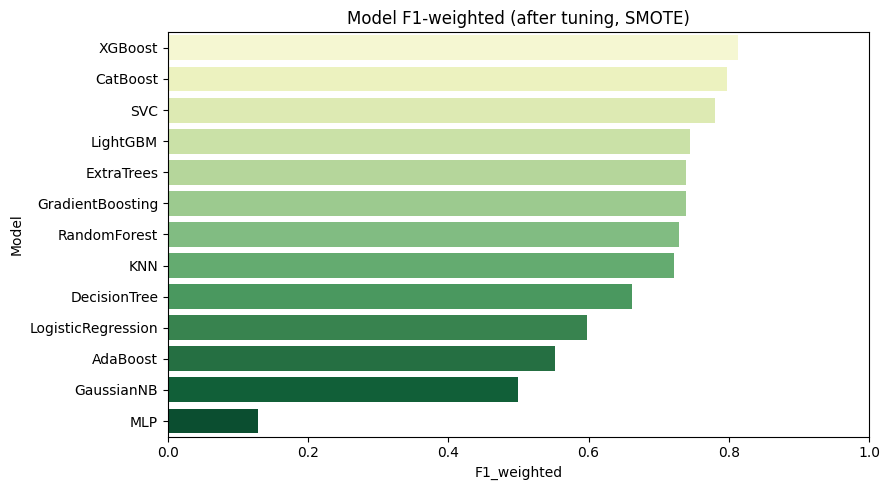

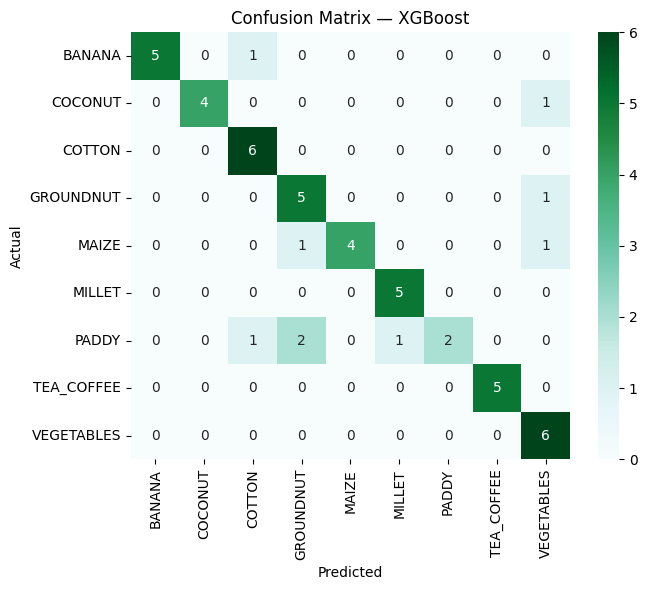


💾 Saved:
  /content/best_tuned_model.pkl
  /content/label_encoder.pkl
  /content/scaler.pkl
  /content/poly_features.pkl
  /content/tuned_model_leaderboard.csv


In [18]:
# ===========================================================
# 🌾 One-Cell: Full Fine-Tuning for 14 Models + SMOTE + Leaderboard
# ===========================================================

# --- Imports
import pandas as pd, numpy as np, warnings, joblib, matplotlib.pyplot as plt, seaborn as sns
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

# Optional libs (skip gracefully if not installed)
try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    import lightgbm as lgb
    HAS_LGB = True
except Exception:
    HAS_LGB = False

try:
    from catboost import CatBoostClassifier
    HAS_CAT = True
except Exception:
    HAS_CAT = False

# --- Config
RANDOM_STATE = 42
N_ITER = 25          # tuning depth: increase for deeper search
CV_FOLDS = 3
np.random.seed(RANDOM_STATE)

# ===========================================================
# 1) Load Dataset
# ===========================================================
df = pd.read_csv("/content/final_dataset1.csv")
print("✅ Dataset loaded:", df.shape)

# ===========================================================
# 2) Drop Rare Crops (<2 samples)
# ===========================================================
vc = df['dominant_crop'].value_counts()
rare = vc[vc < 2].index
df = df[~df['dominant_crop'].isin(rare)].reset_index(drop=True)
print("✅ Removed rare crops. Remaining classes:", df['dominant_crop'].nunique())

# ===========================================================
# 3) Handle Missing Numeric Values
# ===========================================================
num_cols = ['NDVI','Rainfall','Soil_pH']
df[num_cols] = df[num_cols].apply(lambda s: s.fillna(s.mean()))
print("✅ Missing values handled.")

# ===========================================================
# 4) Simple Feature Engineering
# ===========================================================
df['NDVI_Rainfall'] = df['NDVI'] * df['Rainfall']
df['Rainfall_pH']   = df['Rainfall'] * (7 - abs(7 - df['Soil_pH']))
df['NDVI_Soil']     = df['NDVI'] * df['Soil_pH']

FEATURES = ['NDVI','Rainfall','Soil_pH','NDVI_Rainfall','Rainfall_pH','NDVI_Soil']

# ===========================================================
# 5) Encode & Scale
# ===========================================================
le = LabelEncoder()
y = le.fit_transform(df['dominant_crop'])

scaler = MinMaxScaler()
X = scaler.fit_transform(df[FEATURES])

# ===========================================================
# 6) SMOTE
# ===========================================================
# pick safe k_neighbors based on min class size
min_class = pd.Series(y).value_counts().min()
k_neighbors = max(1, min_class - 1)
sm = SMOTE(random_state=RANDOM_STATE, k_neighbors=k_neighbors)
X_res, y_res = sm.fit_resample(X, y)
print("✅ SMOTE applied. New shape:", X_res.shape)

# ===========================================================
# 7) Split
# ===========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=RANDOM_STATE, stratify=y_res
)

# ===========================================================
# 8) Polynomial Features (for NB / LR / MLP)
# ===========================================================
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly  = poly.transform(X_test)

# ===========================================================
# 9) Model zoo + Param grids
# ===========================================================
models = {}
param_grids = {}

models["LogisticRegression"] = LogisticRegression(max_iter=3000, random_state=RANDOM_STATE)
param_grids["LogisticRegression"] = {
    "C": [0.01, 0.1, 1, 5, 10, 20],
    "solver": ["lbfgs", "newton-cg", "saga"],
    "class_weight": [None, "balanced"],
}

models["DecisionTree"] = DecisionTreeClassifier(random_state=RANDOM_STATE)
param_grids["DecisionTree"] = {
    "max_depth": [3,5,7,10,12,15,None],
    "min_samples_split": [2,5,10,20],
    "min_samples_leaf": [1,2,3,5],
    "criterion": ["gini","entropy","log_loss"],
}

models["RandomForest"] = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
param_grids["RandomForest"] = {
    "n_estimators": [200,400,600,800],
    "max_depth": [8,10,12,15,None],
    "min_samples_split": [2,4,6],
    "min_samples_leaf": [1,2,3],
    "class_weight": ["balanced_subsample", None],
    "max_features": ["sqrt", "log2"],
}

models["ExtraTrees"] = ExtraTreesClassifier(random_state=RANDOM_STATE, n_jobs=-1)
param_grids["ExtraTrees"] = {
    "n_estimators": [200,400,600,800],
    "max_depth": [8,10,12,15,None],
    "min_samples_split": [2,4,6],
    "min_samples_leaf": [1,2,3],
    "criterion": ["gini","entropy","log_loss"],
    "max_features": ["sqrt","log2"],
}

models["GradientBoosting"] = GradientBoostingClassifier(random_state=RANDOM_STATE)
param_grids["GradientBoosting"] = {
    "n_estimators": [200,300,400],
    "learning_rate": [0.02,0.05,0.1],
    "max_depth": [2,3,4,5],
    "subsample": [0.7, 0.85, 1.0],
    "min_samples_split": [2,4,6],
}

models["AdaBoost"] = AdaBoostClassifier(random_state=RANDOM_STATE)
param_grids["AdaBoost"] = {
    "n_estimators": [100,200,300,500],
    "learning_rate": [0.5, 1.0, 1.5],
    "algorithm": ["SAMME", "SAMME.R"],
}

if HAS_XGB:
    models["XGBoost"] = xgb.XGBClassifier(
        use_label_encoder=False, eval_metric='mlogloss',
        random_state=RANDOM_STATE, n_jobs=-1, verbosity=0
    )
    param_grids["XGBoost"] = {
        "n_estimators": [300,500,700,900],
        "max_depth": [3,4,5,6,8],
        "learning_rate": [0.02,0.05,0.1],
        "subsample": [0.7, 0.8, 1.0],
        "colsample_bytree": [0.7, 0.9, 1.0],
        "gamma": [0, 1, 5],
    }

if HAS_LGB:
    models["LightGBM"] = lgb.LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
    param_grids["LightGBM"] = {
        "num_leaves": [20,40,60],
        "max_depth": [5,8,12,-1],
        "learning_rate": [0.02,0.05,0.1],
        "n_estimators": [300,600,900,1200],
        "feature_fraction": [0.7, 0.8, 0.9],
        "bagging_fraction": [0.7, 0.8, 1.0],
        "lambda_l1": [0, 1],
        "lambda_l2": [0, 1],
    }

if HAS_CAT:
    models["CatBoost"] = CatBoostClassifier(verbose=0, random_seed=RANDOM_STATE)
    param_grids["CatBoost"] = {
        "iterations": [300,500,800,1000],
        "depth": [4,6,8,10],
        "learning_rate": [0.02,0.05,0.1],
        "l2_leaf_reg": [1,3,5,7],
    }

models["KNN"] = KNeighborsClassifier()
param_grids["KNN"] = {
    "n_neighbors": [3,5,7,9,11,15],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean","manhattan","minkowski"],
}

models["SVC"] = SVC(probability=True, random_state=RANDOM_STATE)
param_grids["SVC"] = {
    "C": [0.1,1,10,50,100],
    "kernel": ["rbf","poly","sigmoid"],
    "gamma": ["scale","auto"],
    "degree": [2,3,4],
}

models["GaussianNB"] = GaussianNB()
param_grids["GaussianNB"] = {
    "var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6]
}

models["MLP"] = MLPClassifier(max_iter=1500, random_state=RANDOM_STATE)
param_grids["MLP"] = {
    "hidden_layer_sizes": [(50,), (100,), (150,), (100,50)],
    "activation": ["relu","tanh"],
    "solver": ["adam","sgd"],
    "learning_rate_init": [0.001,0.01],
    "alpha": [0.0001, 0.001, 0.01],
}

# Which models use polynomial features
USE_POLY = set(["GaussianNB", "LogisticRegression", "MLP"])

# ===========================================================
# 10) Tuning Helper
# ===========================================================
cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
scorer = make_scorer(f1_score, average="weighted")

def tune_and_eval(name, model, param_grid):
    Xtr, Xte = (X_train_poly, X_test_poly) if name in USE_POLY else (X_train, X_test)

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=N_ITER,
        scoring=scorer,
        cv=cv,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=0
    )
    search.fit(Xtr, y_train)
    best = search.best_estimator_
    y_pred = best.predict(Xte)

    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average="weighted")
    f1m = f1_score(y_test, y_pred, average="macro")

    # safe class names (only present labels)
    present = np.unique(y_test)
    class_names = [le.classes_[i] for i in present]

    print(f"\n✅ {name} — Best params: {search.best_params_}")
    print(f"   Accuracy: {acc*100:.2f}% | F1-weighted: {f1w:.3f} | F1-macro: {f1m:.3f}")
    print(classification_report(y_test, y_pred, labels=present, target_names=class_names))

    return {
        "name": name,
        "estimator": best,
        "acc": acc,
        "f1_weighted": f1w,
        "f1_macro": f1m,
        "y_pred": y_pred
    }

# ===========================================================
# 11) Run ALL tunings
# ===========================================================
results = []
for name, model in models.items():
    try:
        res = tune_and_eval(name, model, param_grids[name])
        results.append(res)
    except Exception as e:
        print(f"❌ Skipped {name} due to error: {e}")

# ===========================================================
# 12) Leaderboard + Plot
# ===========================================================
if not results:
    raise RuntimeError("No model successfully tuned. Check data and dependencies.")

board = pd.DataFrame([{"Model": r["name"], "Accuracy": r["acc"], "F1_weighted": r["f1_weighted"], "F1_macro": r["f1_macro"]} for r in results])
board = board.sort_values(["F1_weighted", "Accuracy"], ascending=False).reset_index(drop=True)
print("\n📊 Model Leaderboard (sorted by F1_weighted, then Accuracy):\n", board)

plt.figure(figsize=(9,5))
sns.barplot(data=board, x="F1_weighted", y="Model", palette="YlGn")
plt.title("Model F1-weighted (after tuning, SMOTE)")
plt.xlim(0,1)
plt.tight_layout()
plt.show()

# ===========================================================
# 13) Confusion Matrix of Best Model
# ===========================================================
best_name = board.iloc[0]["Model"]
best = [r for r in results if r["name"] == best_name][0]

# pick X for best
Xtr_best, Xte_best = (X_train_poly, X_test_poly) if best_name in USE_POLY else (X_train, X_test)
y_pred_best = best["estimator"].predict(Xte_best)

plt.figure(figsize=(7,6))
sns.heatmap(confusion_matrix(y_test, y_pred_best),
            annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap="BuGn")
plt.title(f"Confusion Matrix — {best_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ===========================================================
# 14) Save Best Model + Artifacts
# ===========================================================
joblib.dump(best["estimator"], "/content/best_tuned_model.pkl")
joblib.dump(le, "/content/label_encoder.pkl")
joblib.dump(scaler, "/content/scaler.pkl")
joblib.dump(poly, "/content/poly_features.pkl")
board.to_csv("/content/tuned_model_leaderboard.csv", index=False)

print("\n💾 Saved:")
print("  /content/best_tuned_model.pkl")
print("  /content/label_encoder.pkl")
print("  /content/scaler.pkl")
print("  /content/poly_features.pkl")
print("  /content/tuned_model_leaderboard.csv")


# hyperparamter tuning LightGBM, GaussianNB, RF

In [19]:
import joblib

# Assuming you used LabelEncoder on your crop labels
joblib.dump(le_crop, "label_encoder.joblib")
print("✅ Label encoder saved as label_encoder.joblib")
print("Classes:", le_crop.classes_)


✅ Label encoder saved as label_encoder.joblib
Classes: ['BANANA' 'COCONUT' 'COTTON' 'GROUNDNUT' 'MAIZE' 'MILLET' 'PADDY'
 'TEA_COFFEE' 'VEGETABLES']


In [20]:
import joblib

# Load model
model = joblib.load("/content/ExtraTrees_pipeline.joblib")

# Get preprocessing step
preproc = model.named_steps['preproc']

# Get the full feature names used by the model
try:
    feature_names = preproc.get_feature_names_out()
except AttributeError:
    # fallback for older sklearn versions
    feature_names = preproc.get_feature_names()

print("✅ Features used by LightGBM_retrained_pipeline:")
for f in feature_names:
    print("-", f)

print("\nTotal features:", len(feature_names))


✅ Features used by LightGBM_retrained_pipeline:
- num__NDVI
- num__Rainfall
- num__Soil_pH
- num__lat
- num__lon
- num__Shape_Area
- num__Shape_Leng
- cat__Season_Kharif
- cat__Season_Rabi
- cat__Season_Zaid

Total features: 10
